Production Code for Bird Sounder Model
- Build the pipeline to feed in split sound files
- output a csv for model training
- write a method to run in the app that finds the peak and cuts the inputted file (possibly at a couple peaks) to a similar length clip
- use that method to test the model's accuracy against unseen recordings
- youtube videos perhaps (limit the length of the recording that can be inputted), or give a disclaimer that the first couple seconds and last couple will be but out to remoce microphone noises
- give minimum and maximum (suggested) clip lengths to the app user
- 

Additional features to try
#try cepstral coefficiesnts
#try 2nd or third peak, (how to deal with missing values?)
#band pass filter for removing low frequency noise


In [1]:
#read in the csv to pandas
import pandas as pd

#previous files 'bird_train.csv' 'bird_train_test.csv' 'brid_train (copy).csv'
filename = 'bird_train_2_5.csv'
filename = '/'.join( ('feature_tables',  filename) )
data = pd.read_csv(filename)
#create a copy to chop off the target values
data_copy = data.copy(deep=True)
data.tail()

,peak_Hz,peak_Q,peak_mel,fourier_freq,ampmax_n3,ampmax_n2,ampmax_n1,ampmax_0,ampmax_p1,ampmax_p2,...,std_cont1,band_cont2,sum_cont2,min_cont2,max_cont2,mean_cont2,std_cont2,num_samples,sample_rate,species
7064,3122.314453,55,2179.317341,4524,3919.042969,3251.513672,990.527344,3445.312500,925.927734,1787.255859,...,5.059491,4,2188.853193,9.973316,27.727425,17.510826,4.032134,63945,44100,Purple Finch
7065,990.527344,23,812.193401,1426,1119.726562,947.460938,1313.525391,1248.925781,1356.591797,1399.658203,...,3.395468,5,1972.020760,10.831306,25.689254,15.776166,2.597485,63945,44100,Canada Goose
7066,3380.712891,57,2363.324628,5040,1851.855469,1873.388672,4134.375000,3725.244141,3488.378906,3423.779297,...,12.999402,0,2286.430669,4.315509,33.913679,18.291445,3.716284,63945,44100,Red-winged Blackbird
7067,6562.500000,58,2494.548689,9504,3843.750000,3890.625000,3796.875000,6562.500000,6562.500000,6585.937500,...,11.315267,4,2221.315390,9.486910,29.674780,16.333201,3.658251,69600,48000,Carolina Chickadee
7068,861.328125,17,1492.932752,491,1012.060547,2088.720703,2088.720703,5232.568359,1571.923828,2088.720703,...,3.328368,5,1821.258833,10.319883,24.880092,14.570071,2.647525,63945,44100,Mallard


In [ ]:
import seaborn as sns
data.columns

In [ ]:

#sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data)

In [ ]:
df = data.drop(columns=['num_samples', 'sample_rate', 'species'])#, inplace=True )

In [ ]:
data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the correlation matrix

corr = data.corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#g = sns.pairplot(data, hue="species")
#sns.__version__

In [2]:
species_col.value_counts().sum()

NameError: name 'species_col' is not defined

Text(0.5, 1.0, 'Clip Counts per Species')

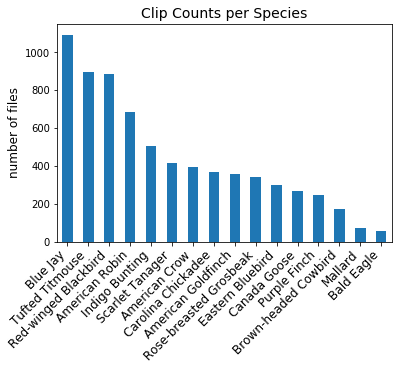

In [3]:
#data.species.plot.hist()
ax = data.species.value_counts().plot(kind='bar')
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12 )
ax.set_ylabel('number of files', fontsize=12)
ax.set_title('Clip Counts per Species', fontsize=14)

American Crow             215
Canada Goose              183
Blue Jay                   76
Red-winged Blackbird       72
Tufted Titmouse            56
Indigo Bunting             44
Scarlet Tanager            39
Mallard                    39
American Robin             34
Carolina Chickadee         22
Eastern Bluebird           19
Brown-headed Cowbird       14
Rose-breasted Grosbeak     12
Purple Finch               12
American Goldfinch          8
Bald Eagle                  2
Name: species, dtype: int64

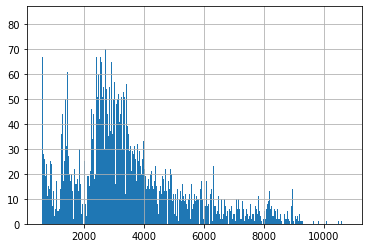

In [4]:
#check the peak frequency distribution
data.peak_Hz.hist(bins=500)
data[ data.peak_Hz < 1420 ].species.value_counts()

Series([], Name: species, dtype: int64)

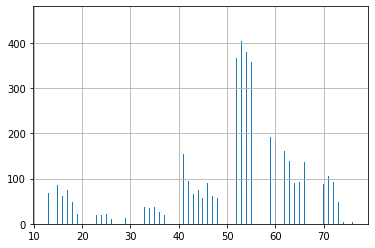

In [5]:
#check the constant Q frequency distribution
data.peak_Q.hist(bins=500)
data[ data.peak_Q < 10 ].species.value_counts()

Canada Goose              82
American Crow             77
Blue Jay                  42
Indigo Bunting            36
Scarlet Tanager           32
Red-winged Blackbird      29
Mallard                   29
Tufted Titmouse           25
American Robin            22
Carolina Chickadee        14
Brown-headed Cowbird      10
Rose-breasted Grosbeak     7
Purple Finch               7
Eastern Bluebird           5
American Goldfinch         2
Bald Eagle                 1
Name: species, dtype: int64

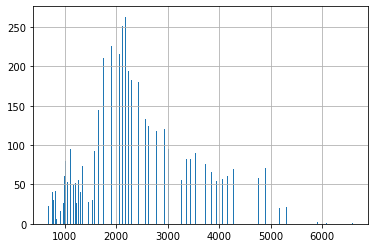

In [6]:
#check the mel frequency distribution
data.peak_mel.hist(bins=500)

data[ data.peak_mel < 1000 ].species.value_counts()

In [7]:
#use OneHot encoding to transform categorical data into something useful
from sklearn.preprocessing import OneHotEncoder
#simple imputer will handle missing values
from sklearn.impute import SimpleImputer
#chain together multiple transformations in one custom filter
from sklearn.pipeline import Pipeline
#select (by column header/key) which columns get which kind of transformation
from sklearn.compose import ColumnTransformer

In [8]:
#choose which columns get transformed
cat_cols = ['species']
#create the pipeline
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))

#combine the two transformations into a single Pipeline
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)

target_fit_transformed = ct.fit_transform(data)
target_transformed = ct.transform(data) #fit shouldnt matter for one-hot encoding

pd.DataFrame( target_fit_transformed ).tail(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
7063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7065,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#remove the species column from the test dataframe
species_col = data.pop('species')

In [10]:
#get the feature names from the transformation
all_steps = ct.named_transformers_['cat']
ohe = all_steps.named_steps['ohe']
cat_feature_names = ohe.get_feature_names()
#clean up the feature names to make more readable
ohe_column_names = [cfn.strip('x0_').strip() for cfn in cat_feature_names]
cat_feature_names, ohe_column_names 

(array(['x0_American Crow', 'x0_American Goldfinch', 'x0_American Robin',
        'x0_Bald Eagle', 'x0_Blue Jay', 'x0_Brown-headed Cowbird',
        'x0_Canada Goose', 'x0_Carolina Chickadee', 'x0_Eastern Bluebird',
        'x0_Indigo Bunting', 'x0_Mallard', 'x0_Purple Finch',
        'x0_Red-winged Blackbird', 'x0_Rose-breasted Grosbeak',
        'x0_Scarlet Tanager', 'x0_Tufted Titmouse'], dtype=object),
 ['American Crow',
  'American Goldfinch',
  'American Robin',
  'Bald Eagle',
  'Blue Jay',
  'Brown-headed Cowbird',
  'Canada Goose',
  'Carolina Chickadee',
  'Eastern Bluebird',
  'Indigo Bunting',
  'Mallard',
  'Purple Finch',
  'Red-winged Blackbird',
  'Rose-breasted Grosbeak',
  'Scarlet Tanager',
  'Tufted Titmouse'])

Use stratified random sample for the test/train split
this will preserve species ratios of the data in train/test split

In [ ]:
#initialize a random forest regressor model
from sklearn.ensemble import RandomForestRegressor


max_depth = 30

regr_rf = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, 
                                random_state=12)#



In [ ]:
#from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
from sklearn.metrics import r2_score

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.7, random_state=42)

#one hot encoding target
X,y = np.array(data), np.array(target_transformed)
#string target
#X,y = np.array(data), np.array(species_col)




In [ ]:
for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #fit the model with the new vaues
    regr_rf.fit(X_train, y_train)
    #evaluate the fit accuracy
    #print(regr_rf.score(X_test, y_test))
    y_pred = regr_rf.predict(X_test)#, y_test)#, multioutput='uniform_average')
    print( r2_score(y_test, y_pred) )

In [ ]:
for feat,imp in zip(data.columns, regr_rf.feature_importances_):
    print(feat.strip(), imp)

In [ ]:

regr_rf.fit(X_train, y_train)
#evaluate the fit accuracy
regr_rf.score(X_test, y_test)
#y_pred = regr_rf.predict(X_test)#, y_test)#, multioutput='uniform_average')

#r2_score(y_test, y_pred) #...          multioutput='variance_weighted')
#y_pred, y_pred.shape, y_test.shape

In [11]:
from sklearn.metrics import f1_score

def GetF1Scores( y_test, y_pred ):
    f1macro = f1_score(y_test, y_pred, average='macro')
    f1micro = f1_score(y_test, y_pred, average='micro')
    f1weighted = f1_score(y_test, y_pred, average='weighted')
    f1none = f1_score(y_test, y_pred, average=None)

    return f1macro, f1micro, f1weighted#, f1none

In [20]:
#string target
import numpy as np

X,y = np.array(data), np.array(species_col)

from sklearn.ensemble import GradientBoostingClassifier
#recalls
params_prec = {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 200} #prec hyper-tuned for v2 9_species
params = {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 150} #params hyper-tuned for v2 (9 birds 14 features)
cbg = GradientBoostingClassifier( )# **params )

In [21]:
#loop through a series of splits to score the model and check the consistency across splits
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.7, random_state=42)
from sklearn.metrics import classification_report

ds = []
outdict = True

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cbg.fit(X_train, y_train)
    y_pred = cbg.predict( X_test )
    #confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
    #PrintConfusionMatrix(confusion_matrix.values, confusion_matrix.columns, normalize=True);
    print(GetF1Scores( y_test, y_pred ) )
    CR = classification_report(y_test, y_pred, output_dict=outdict )
    if not outdict:
        print( CR )
    ds.append( CR )#classification_report(y_test, y_pred))#, output_dict=True ) )

(0.5490422793374663, 0.619114972721762, 0.6131389414272819)
(0.5394546039640157, 0.6108304708021822, 0.6022268985720254)
(0.523111558788288, 0.6015356637704586, 0.5929824088241749)
(0.5360916607083952, 0.6067892503536068, 0.597676865528593)
(0.5245132771818937, 0.6092139826227521, 0.5985597798761251)


In [22]:
#how the model works...be able to explain
#grid based hyper parameter searach
#sklearn paramater search...
#"I did the parameter tuning"

cbg.fit(X_train, y_train)

y_pred = cbg.predict(X_test)
cbg.score(X_test, y_test)
#print( r2_score(y_test, y_pred) )

0.6090119216003232

In [25]:
from sklearn.metrics import r2_score
print( r2_score(y_test, y_pred) )

ValueError: could not convert string to float: 'Eastern Bluebird'

In [26]:
d = classification_report(y_test, y_pred, output_dict=True )
#d
#print(d)
#d['accuracy'], d['macro avg'], d['weighted avg'],

In [27]:
#get the results from the loop of splits

def GetReportResults( ds ):
    accuracies = [d['accuracy'] for d in ds]
    #macro scores
    macro_pres = [d['macro avg']['precision'] for d in ds]
    macro_recall = [d['macro avg']['recall'] for d in ds]
    macro_f1 = [d['macro avg']['f1-score'] for d in ds]
    macro_support = [d['macro avg']['support'] for d in ds]
    #weighted scores
    weighted_pres = [d['weighted avg']['precision'] for d in ds]
    weighted_recall = [d['weighted avg']['recall'] for d in ds]
    weighted_f1 = [d['weighted avg']['f1-score'] for d in ds]
    weighted_support = [d['weighted avg']['support'] for d in ds]
    print('avg accuracy: {:.3f}'.format( np.average(accuracies) ) )
    print('macro')
    print(' avg_prescision avg_recall avg_macro')
    print('{:.3} {:.3} {:.3}'.format( np.average(macro_pres), np.average(macro_recall), np.average(macro_f1)))
    print('weighted')
    print( '{:.3} {:.3} {:.3}'.format( np.average(weighted_pres), np.average(weighted_recall), np.average(weighted_f1)))

GetReportResults( ds )

avg accuracy: 0.609
macro
 avg_prescision avg_recall avg_macro
0.583 0.514 0.534
weighted
0.61 0.609 0.601


In [28]:
#f1 scores for default values
#they are actually worse...change the hyperparameter tuning properties...
GetF1Scores( y_test, y_pred )

(0.5264268597502841, 0.6090119216003232, 0.5991648601698497)

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix

def MakeConfusionMatrix( y_test, y_pred ):
    data = {'y_Actual':   y_test,
            'y_Predicted': y_pred
            }

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

    print( confusion_matrix.shape )
    confusion_matrix = confusion_matrix[:-1]
    print( confusion_matrix.shape )
    confusion_matrix.drop(columns=['All'], inplace=True)


    ##plt.figure(figsize=(14,10))
    ##sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    '''disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=True)'''
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    #b, t = plt.ylim() # discover the values for bottom and top
    #b += 0.5 # Add 0.5 to the bottom
    #t -= 0.5 # Subtract 0.5 from the top
    ##plt.ylim(b, t) # update the ylim(bottom, top) values
    ##plt.show() # ta-da!
    return confusion_matrix

confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
#confusion_matrix.values, confusion_matrix.columns

(17, 17)
(16, 17)


(17, 17)
(16, 17)
Normalized confusion matrix
Confusion matrix, without normalization


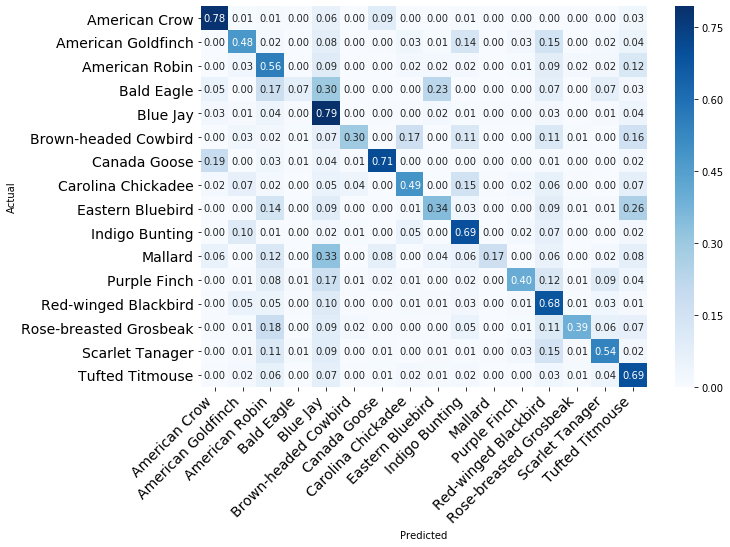

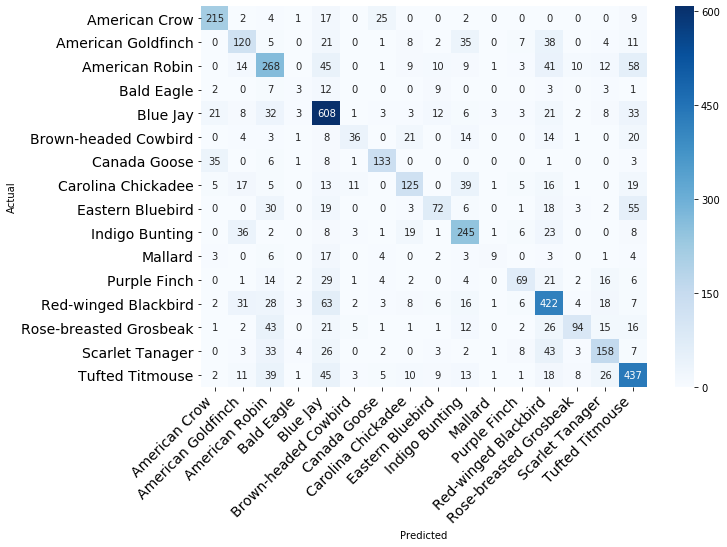

In [32]:
#modified from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, normalize=False, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        #print(confusion_matrix)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fmt = '.2f' if normalize else 'd'
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return fig

confusion_matrix = MakeConfusionMatrix( y_test, y_pred )
print_confusion_matrix(confusion_matrix.values, confusion_matrix.columns, normalize=True);
print_confusion_matrix(confusion_matrix.values, confusion_matrix.columns);

num_samples 0.000
sample_rate 0.002
band_cont0 0.003
max_cont1 0.007
band_cont1 0.008
band_cont2 0.009
flat_std 0.009
flat_max 0.009
min_cont2 0.011
sum_cont1 0.011
flat_mean 0.013
max_cont2 0.014
flat_min 0.014
rolloff_max 0.015
sum_cont0 0.015
sum_cont2 0.015
rolloff_mean 0.016
mean_cont1 0.017
min_cont1 0.017
rms_std 0.017
ampmax_n3 0.017
ampmax_n2 0.018
min_cont0 0.018
mean_cont2 0.021
rms_max 0.021
rms_min 0.022
ampmax_p2 0.022
rolloff_std 0.027
peak_Q 0.028
std_cont2 0.029
mean_cont0 0.029
std_cont1 0.030
rms_mean 0.030
ampmax_p1 0.032
max_cont0 0.035
std_cont0 0.037
fourier_freq 0.040
ampmax_n1 0.043
peak_mel 0.051
peak_Hz 0.058
rolloff_min 0.072
ampmax_0 0.101


Text(0.5, 1.0, 'Feature Importance')

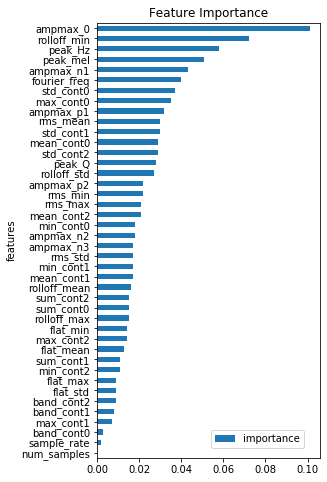

In [33]:
dfin = []
for feat,imp in sorted( zip(data.columns, cbg.feature_importances_), key=lambda l:l[1]):#, reverse=True):
    print(feat.strip(), '{:.3f}'.format(imp) )
    dfin.append( (feat.strip(), '{:.3f}'.format(imp)) )
df = pd.DataFrame(dfin)
df.columns = 'features', 'importance'
#df.set_index('features', drop=True, inplace=True)
df.importance = df.importance.astype(float)
f,ax = plt.subplots( figsize=(4,8) )
df.plot.barh(x='features', y='importance', ax=ax ).legend(bbox_to_anchor=(0.95, 0.075))
ax.set_title( 'Feature Importance' )

In [89]:
cbg.classes_

array(['American Crow', 'American Goldfinch', 'American Robin',
       'Bald Eagle', 'Blue Jay', 'Brown-headed Cowbird', 'Canada Goose',
       'Carolina Chickadee', 'Eastern Bluebird'], dtype=object)

In [90]:
#hyperparameter tuning for gradient boost classifier
#modified from  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
tuned_parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[2,3,4,5,6,8],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10, 25, 50, 100, 150, 200]
    }

#score on prescision and recall...
#clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

scores = ['precision', 'recall']

for score in scores:
    print(f'# Tuning hyper-parameters for {score}\n')
    #using macro scoring...try weighted after? ...for micro, prescision=acuracy...for multiclass
    clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters,
                       scoring=f'{score}_macro', cv=10, n_jobs=-1)
    #clf = GridSearchCV( svm.SVC(), tuned_parameters, scoring=f'{score}_macro' )
    clf.fit( X_train, y_train )
    print('best params found on development set\n')
    print( clf.best_params_ )
    print('\ngrid scores on development set:')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean,std,params in zip( means, stds, clf.cv_results_['params'] ):
        print('{:.3f} +/-{:.3f} for {}'.format( mean, 2*std, params) )
        print('classification report:\n')
        y_true, y_pred = y_test, clf.predict( X_test )
        print( classification_report(y_true, y_pred ) )

# Tuning hyper-parameters for precision

best params found on development set

{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 200}

grid scores on development set:
0.032 +/-0.000 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
 

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.095 +/-0.082 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.518 +/-0.149 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.104 +/-0.024 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.515 +/-0.108 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.362 +/-0.136 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.556 +/-0.142 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.500 +/-0.207 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.516 +/-0.095 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.473 +/-0.104 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.554 +/-0.155 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.486 +/-0.153 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.522 +/-0.106 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.477 +/-0.112 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.557 +/-0.166 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.491 +/-0.160 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.522 +/-0.099 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.510 +/-0.141 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.557 +/-0.173 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.502 +/-0.156 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.524 +/-0.089 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.520 +/-0.131 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.577 +/-0.138 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.500 +/-0.155 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.514 +/-0.112 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.511 +/-0.138 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.549 +/-0.160 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.515 +/-0.181 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.538 +/-0.139 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.514 +/-0.131 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.563 +/-0.179 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.70      0.77      0.73       354
  American Goldfinch       0.68      0.64      0.66       298
      American Robin       0.62      0.61      0.62       609
          Bald Eagle       0.30      0.16      0.21        43
            Blue Jay       0.65      0.73      0.69       866
Brown-headed Cowbird       0.52      0.33      0.41       141
        Canada Goose       0.68      0.57      0.62       215
  Carolina Chickadee       0.60      0.67      0.63       294
    Eastern Bluebird       0.51      0.40      0.45       225

            accuracy                           0.64      3045
           macro avg       0.58      0.54      0.56      3045
        weighted avg       0.63      0.64      0.63      3045

0.505 +/-0.150 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.404 +/-0.066 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.116 +/-0.007 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.467 +/-0.096 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.132 +/-0.013 for {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.464 +/-0.084 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.274 +/-0.038 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.508 +/-0.106 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.365 +/-0.068 for {'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.495 +/-0.120 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.404 +/-0.079 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.516 +/-0.122 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.412 +/-0.100 for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.496 +/-0.143 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.435 +/-0.084 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.508 +/-0.123 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

   

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.438 +/-0.122 for {'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.500 +/-0.127 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.466 +/-0.105 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.521 +/-0.117 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.453 +/-0.139 for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.503 +/-0.111 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.490 +/-0.117 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.524 +/-0.130 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.447 +/-0.127 for {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.499 +/-0.119 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.517 +/-0.137 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.526 +/-0.101 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.468 +/-0.134 for {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

      

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.514 +/-0.111 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.508 +/-0.132 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.529 +/-0.122 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
classification report:

                      precision    recall  f1-score   support

    

                      precision    recall  f1-score   support

       American Crow       0.68      0.77      0.72       354
  American Goldfinch       0.68      0.63      0.66       298
      American Robin       0.64      0.62      0.63       609
          Bald Eagle       0.18      0.19      0.18        43
            Blue Jay       0.67      0.74      0.70       866
Brown-headed Cowbird       0.48      0.30      0.37       141
        Canada Goose       0.68      0.55      0.61       215
  Carolina Chickadee       0.59      0.69      0.64       294
    Eastern Bluebird       0.59      0.42      0.49       225

            accuracy                           0.64      3045
           macro avg       0.58      0.55      0.56      3045
        weighted avg       0.64      0.64      0.63      3045

0.487 +/-0.132 for {'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}
classification report:

                      precision    recall  f1-score   support

     

In [ ]:
#precision
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 200}
#recall

{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 150}

In [ ]:
i = 20
for i in range(20):
    single = X_test[i].reshape(1,-1) 
    single_ans = y_test[i]

    ab = cbg.predict( single )
    probas = cbg.predict_proba( single )
    #log_probas = cbg.predict_log_proba( single )

    top_results = sorted( zip( cbg.classes_, probas[0] ), key=lambda l: l[1], reverse=True )


    print( f'actual {y_test[i]}, predicted {ab}, top_proba=predicted? {ab[0]==top_results[0][0]}' )
    for res in zip(  top_results[:3]  ):
        print(res)
    print()
    

In [ ]:
#best params found on development set

best_params = {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 10, 'subsample': 0.9}

In [ ]:
#compare default with best params found from hyper paramter tuning
cbg = GradientBoostingClassifier( **best_params )
cbg.fit(X_train, y_train)

y_pred = cbg.predict(X_test)
cbg.score(X_test, y_test)

In [ ]:
#f1 scores for 'best' values
GetF1Scores( y_test, y_pred )

sensitivity and specificity, prescision recall, -> short blub about what it says __ talk about two that people ususally use...how well it can predict.  how good is it at false discovery 

roc curve, what youd like to see goes stainght up then stairght down

get rid of bottom row...

reason of why XGboost...why did i choose it

Export the model parameters to feed into the App

In [ ]:
#write the resulting model parameters with joblib
from joblib import dump, load
dump(cbg, 'cbg_model.joblib') 
#test the loading of the model to verify it's functionality
cbg_loaded = load('cbg_model.joblib') 

In [ ]:
#cbg.fit(X_train, y_train)

y_pred = cbg_loaded.predict(X_test)
cbg_loaded.score(X_test, y_test)

In [ ]:
from sklearn.metrics import classification_report
print( classification_report(y_true, y_pred ) )

In [ ]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

tuned_parameters = [ {'kernel': ['rbf'], 'gamma': [1e-3],# 1e-4],
                      'C': [1, 10]},#, 100, 1000]},
                     {'kernel': ['linear'], 'C': [1, 10]}]#, 100, 1000]} ]

scores = ['precision', 'recall']

for score in scores:
    print(f'# Tuning hyper-parameters for {score}\n')
    
    clf = GridSearchCV(
        svm.SVC(), tuned_parameters, scoring=f'{score}_macro', n_jobs=-1 )
    clf.fit( X_train, y_train )
    print('best params found on development set\n')
    print( clf.best_params_ )
    print('\ngrid scores on development set:\n')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean,std,params in zip( means, stds, clf.cv_results_['params'] ):
        print('{:.3f} +/-{:.3f} for {}'.format( mean, 2*std, params) )
        print('classification report:\n')
        y_true, y_pred = y_test, clf.predict( X_test )
        print( classification_report(y_true, y_pred ) )
    break

In [11]:
y.shape, y

((4349, 9), array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int64))

In [12]:
#Reciever operator curve for multi class classifier
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit

# Import some data to play with
##iris = datasets.load_iris()
##X = iris.data
##y = iris.target

# Binarize the output
##y = label_binarize(y, classes=[0, 1, 2])
y = label_binarize(y, classes=ohe_column_names )
n_classes = y.shape[1]

# Add noisy features to make the problem harder
#random_state = np.random.RandomState(0)
#n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 20 * n_features)]

# shuffle and split training and test sets
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Learn to predict each class against the other
#classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
classifier = OneVsRestClassifier(GradientBoostingClassifier( random_state=random_state),n_jobs=-1)
                                 #random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

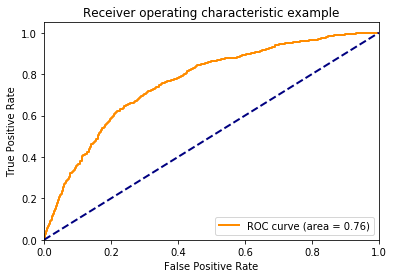

In [13]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

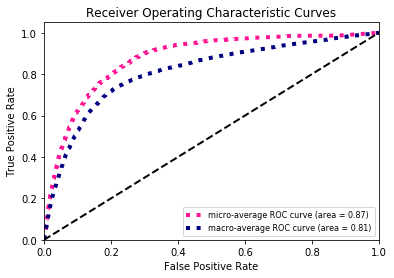

In [100]:
#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

'''
##colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
                'tab:gray', 'tab:olive', 'tab:cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
'''
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right", fontsize=8)
plt.show()

In [ ]:
for mean,std,params in zip( means, stds, clf.cv_results_['params'] ):
        print('{:.3f} +/-{:.3f} for {}'.format( mean, 2*std, params) )
        print('classification report:\n')
        y_true, y_pred = y_test, clf.predict( X_test )
        print( classification_report(y_true, y_pred ) )

take the ratio for the 'all' row and column for each species, to determine the percentage of each species that was predicted corretly
- if it is over 1, then it was 'over-fitted' to that species (i.e. it predicted that species more that there actually were'
- if it is less, then (i would think) this is better since it just mis-identified things and not thought everything was just "a blue jay" because the data set was mostly bue jays

In [ ]:
#tn, tp are diagonals
#fp = top predicted true, but actually false
#fn = predicted false, but actually true
#tn,fp,fn,tp = confusion_matrix.ravel()
CM = np.array(confusion_matrix)
tnfp = CM.ravel()
tp = 0
n = 0
fp = 0
fn = 0
print(CM.shape)
for i,row in enumerate(CM):
    for j,col in enumerate(row):
        n += col
        #print(i,j, CM[i][j], col)
        if i==j:
            tp += col #CM[i][j]
        if i>j:
            fn += col
        if i<j: fp += col

            
#confusion_matrix.all
tp, n, fp, fn

In [ ]:
CM = multilabel_confusion_matrix(y_test, y_pred)

In [ ]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(x_train, y_train)
model.score(x_test,y_test)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
#multilabel_confusion_matrix(y_test, y_predicted)  #give error due to continous output of RF regressor
#y_pred = (y_pred > 0.5) 
CM = multilabel_confusion_matrix(y_test, y_pred)
#CM = confusion_matrix(y_test, y_pred)
#CMml, CMml.shape
plt.figure()
sns.heatmap(CM[:,:,1], annot=True)
plt.tight_layout()

plt.figure()

sns.heatmap(CM[:,:,0], annot=True)
plt.tight_layout()
CM.shape, CM[:,:,0]
#sn.heatmap(CM, annot=True)
pd.DataFrame(y_pred).head()

In [ ]:
from sklearn.multioutput import MultiOutputRegressor


regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=1000, max_depth=max_depth, random_state=12))
regr_multirf.fit(X_train, y_train)
regr_multirf.score(X_test, y_test)

In [ ]:
label_one = ('zero', 'one')
label_two = ohe_column_names
cols = pd.MultiIndex.from_product([label_one, label_two])

pd.DataFrame(CM.T.reshape(2, -1), columns=cols)

In [ ]:
import seaborn as sn
#get the prediction results
y_predicted = regr_rf.predict(X_test)
#store the actual answers and the predicted answers in a DataFrame
prediction_data = {'y_Actual':   y_test,
        'y_Predicted': y_predicted }

df = pd.DataFrame( y_predicted, y_test )
#df = pd.DataFrame(prediction_data)#, columns=['y_Actual','y_Predicted'])
#calculate the confusion matrix
##confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

#plot the heatmap using seaborn
##sn.heatmap(confusion_matrix, annot=True)
#df = pd.DataFrame(prediction_data, columns=['y_Actual','y_Predicted'])
#y_test
df

In [ ]:
#ratio of species in train vs test (ideally should be ~3 for all)
train, test = pd.DataFrame( y_train ), pd.DataFrame( y_test )
train.columns, test.columns = ['species'], ['species']
train.species.value_counts()/test.species.value_counts(), test.species.value_counts()


In [ ]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train)
clf.score(X_test, y_test)


In [ ]:
predicted = regr_rf.predict(X_test)
for i,prediction in enumerate(predicted):
    print(i, y_test[i] - prediction)
    #print( sum(y_test[i] - prediction))

In [ ]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

a = ((-1, 1, 2, 'a'),
     (3, 4, 2, 'b'),
     (6, 7, 3, 'c'),
     (9, 10, 3, 'd'))

df = pd.DataFrame( a )
df.columns = 'first second third letters'.split()
g_works = sns.pairplot(df)
g_broken = sns.pairplot(df, hue="letters")